# Tweets Data Clean

In [40]:
import pandas as pd

In [41]:
tweet = pd.read_csv('../data/twitter_match_mbti.csv')

In [42]:
tweet.drop(columns = 'Unnamed: 0',inplace = True)

In [43]:
tweet.rename(columns = {'Unnamed: 0.1':'name'},inplace = True)

In [44]:
cols = tweet.columns.tolist()
cols = cols[-1:] + cols[:-1]

In [45]:
tweet = tweet[cols]

In [46]:
tweet['posts'] = tweet.iloc[:,2:].fillna('%^&').apply(' ||| '.join, axis =1)

In [47]:
# x=tweet['posts'][0]
# x.replace('||| %^&','')

In [48]:
tweet.posts = tweet.posts.apply(lambda x: x.replace('||| %^&',''))

In [129]:
tweet['posts'][1]

"RT @TMobile: We're throwing the ultimate New Year's Eve celebration with @JustinBieber 🙌\nGet your #BieberNYE livestream access today! ||| See you on New Year’s Eve. #BieberNYE on sale globally now. Free for @tmobile customers in the US. Buy access at https://t.co/G6hpTIPnbO https://t.co/cWa4kajLF0 ||| Doing a little something with @tmobile on 12.31.20 https://t.co/r5iaCnY2rW #BieberNYE https://t.co/5pSRmD2rLF ||| That time of year... \nhttps://t.co/uMJKBWwLbc https://t.co/suIB5DEFZY           "

### remove emoji

In [127]:
import re

text = u'This is a smiley face \U0001f602'
print(text) # with emoji

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)


This is a smiley face 😂


In [137]:
tweet['deEmojify'] = tweet['posts'].apply(deEmojify)

# Feature Engineering

In [52]:
def posts_split(posts):
    # split the posts column into 50 separate posts in a list
    posts_split = posts.split('|||')
    # split each of the 50 posts into a list of its words/URL links
    # so we have a list of 50 posts and each post is a list of the words/URL links
                
    return posts_split

In [53]:
tweet['posts_split'] = tweet['posts'].apply(posts_split)

In [138]:
tweet['deEmojify'] = tweet['deEmojify'].apply(posts_split)

In [140]:
tweet_clean = tweet.drop(columns = cols[2:17])

In [87]:
def remove_links(post_split):
    # split each post into a list of individual words
    post_split_split = [x.split(' ') for x in post_split]
    
    # removes any 'words' that have http:// or https:// in them
    return_list = [[item for item in sentence if ('http://' not in item and 'https://' not in item)] for sentence in post_split_split]
    
    # returns a list of posts if they are not empty after removing the links
    return [' '.join(sentence) for sentence in return_list if sentence]

In [143]:
tweet_clean['link_free'] = tweet_clean['deEmojify'].apply(remove_links)

## 1. Readability

In [145]:
import syllables
def sentence_count(post):
    return len(post)

def word_count(post):
    count = 0
    for sentence in post:
        count += len(sentence.split())
    return count

def syll_count(X):
    count_syll = 0
    syll_count_ls = []
    for sentence in X:
        sentence = sentence.split()
        for word in sentence:
            count_syll +=  syllables.estimate(word)
        syll_count_ls.append(count_syll)
    return count_syll

In [146]:
tweet_clean['sentence_count'] = tweet_clean['link_free'].apply(sentence_count)

In [147]:
tweet_clean['syll_count'] = tweet_clean['link_free'].apply(syll_count)

In [148]:
tweet_clean['word_count'] = tweet_clean['link_free'].apply(word_count)

In [176]:
tweet_clean.rename(columns = {'link_free':'link_free_without_emoji'},inplace = True)

In [119]:
tweet_sum = tweet_clean.groupby(['MBTI']).sum()
tweet_sum 

,sentence_count,word_count,syll_count
MBTI,,,
ENFJ,218,4386,7278
ENFP,409,5803,9478
ENTJ,118,1756,2718
ENTP,379,6040,10035
ESFJ,445,9251,14882
ESFP,588,9109,15281
ESTJ,242,4823,7831
ESTP,242,3652,6155
INFJ,143,2946,4216


In [120]:
def readability(X):
    X['readability'] = 206.835 - 1.015*(X['word_count']/X['sentence_count']) -84.6*(X['syll_count']/X['word_count'])
    return X

In [150]:
tweet_sum = tweet_sum.apply(lambda x: readability(x), axis = 1)

In [156]:
tweet_sum.sort_values(by = ['readability'],inplace = True)

In [152]:
import matplotlib.pyplot as plt

<BarContainer object of 16 artists>

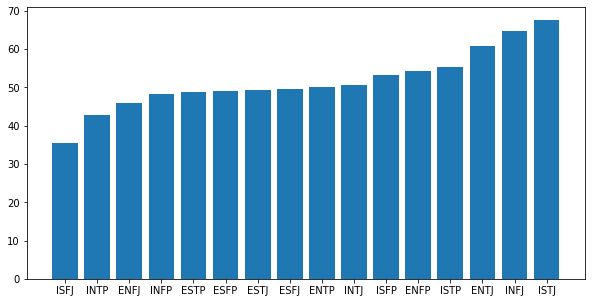

In [162]:
plt.figure(figsize = (10,5))
plt.bar(tweet_sum.index, height =tweet_sum['readability'])

## 2. Average Word per Sentence

In [165]:
tweet_sum ['word_per_sentence'] = tweet_sum ['word_count']/tweet_sum['sentence_count']

In [170]:
tweet_sum.sort_values(by = ['word_per_sentence'],inplace = True)

<BarContainer object of 16 artists>

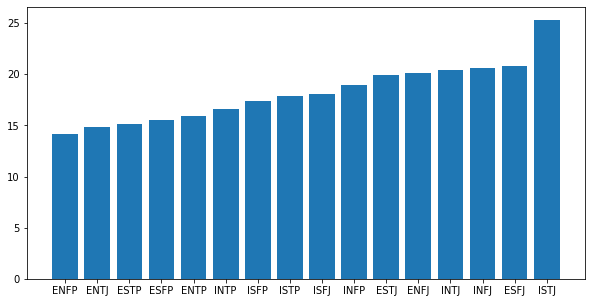

In [171]:
plt.figure(figsize = (10,5))
plt.bar(tweet_sum.index, height = tweet_sum ['word_per_sentence'])

## 3. Average Word Length

In [173]:
def avg_word_length(posts_split):
    word_length_count = []
    count = 0
    for post in posts_split:
        count += len(post)  
    return count

In [181]:
tweet_clean['word_length']=tweet_clean['link_free_without_emoji'].apply(avg_word_length)

In [184]:
tweet_sum = tweet_clean.groupby(['MBTI']).sum()

In [186]:
tweet_sum

,sentence_count,syll_count,word_count,word_length
MBTI,,,,
ENFJ,218,7244,4352,26603
ENFP,409,9351,5676,35406
ENTJ,118,2690,1728,10878
ENTP,379,9978,5983,37412
ESFJ,445,14807,9176,55480
ESFP,588,15056,8884,57314
ESTJ,242,7768,4760,30266
ESTP,242,6085,3582,23155
INFJ,143,4188,2918,17906


In [187]:
tweet_sum['avg_word_length'] = tweet_sum['word_length']/tweet_sum['word_count']

<BarContainer object of 16 artists>

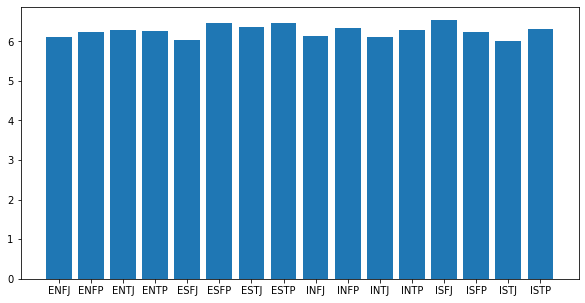

In [190]:
plt.figure(figsize = (10,5))
plt.bar(tweet_sum.index, height = tweet_sum ['avg_word_length'])

## 4. Type to token ratio
> A type-token ratio (TTR) is the total number of UNIQUE words (types) divided by the total number of words (tokens/word_count) in a given segment of language.<br>
> __The closer the TTR ratio is to 1, the greater the lexical richness of the segment.__ <br>
> link: https://carla.umn.edu/learnerlanguage/spn/comp/activity4.html#:~:text=A%20type%2Dtoken%20ratio%20(TTR,a%20given%20segment%20of%20language.&text=The%20closer%20the%20TTR%20ratio,lexical%20richness%20of%20the%20segment.

In [209]:
from collections import Counter

In [210]:
def count_unique_word(posts):
    count_unique = len(Counter(posts))
    return count_unique

In [211]:
tweet_clean['count_unique_word'] = tweet_clean['link_free_without_emoji'].apply(count_unique_word)

In [213]:
tweet_clean

,MBTI,name,posts,posts_split,punc_free,deEmojify,link_free_without_emoji,sentence_count,syll_count,word_count,word_length,count_unique_word
0,ENTP,BarackObama,"In A Promised Land, I talk about the decisions...","[In A Promised Land, I talk about the decision...",[In A Promised Land I talk about the decision...,"[In A Promised Land, I talk about the decision...","[In A Promised Land, I talk about the decision...",7,303,201,1119,7
1,ESFP,justinbieber,RT @TMobile: We're throwing the ultimate New Y...,[RT @TMobile: We're throwing the ultimate New ...,[RT TMobile We re throwing the ultimate New ...,[RT @TMobile: We're throwing the ultimate New ...,[RT @TMobile: We're throwing the ultimate New ...,4,84,52,342,4
2,ESFP,katyperry,"🎶I don’t need diamonds, no sparkly things, cau...","[🎶I don’t need diamonds, no sparkly things, ca...",[🎶I don’t need diamonds no sparkly things ca...,"[I don’t need diamonds, no sparkly things, cau...","[I don’t need diamonds, no sparkly things, cau...",8,133,91,529,8
3,ISFP,rihanna,Just me pullin up to Sephora to make sure @fen...,[Just me pullin up to Sephora to make sure @fe...,[Just me pullin up to Sephora to make sure fe...,[Just me pullin up to Sephora to make sure @fe...,[Just me pullin up to Sephora to make sure @fe...,1,50,34,211,1
4,ESFP,Cristiano,We all miss the supporters in the stadiums and...,[We all miss the supporters in the stadiums an...,[We all miss the supporters in the stadiums an...,[We all miss the supporters in the stadiums an...,[We all miss the supporters in the stadiums an...,4,182,126,712,4
...,...,...,...,...,...,...,...,...,...,...,...,...
418,ENFP,WillyrexYT,Empezamos CYBERPUNK en DIRECTO!! https://t.co/...,[Empezamos CYBERPUNK en DIRECTO!! https://t.co...,[Empezamos CYBERPUNK en DIRECTO https t co...,[Empezamos CYBERPUNK en DIRECTO!! https://t.co...,"[Empezamos CYBERPUNK en DIRECTO!! , en 5h el ...",15,332,183,1105,15
419,ISTP,1future,Juice still dropping classics til this day. Le...,[Juice still dropping classics til this day. L...,[Juice still dropping classics til this day L...,[Juice still dropping classics til this day. L...,[Juice still dropping classics til this day. L...,4,60,38,251,4
420,INFJ,NASAHubble,Explore the Crab Nebula...but make it musical!...,[Explore the Crab Nebula...but make it musical...,[Explore the Crab Nebula but make it musical...,[Explore the Crab Nebula...but make it musical...,[Explore the Crab Nebula...but make it musical...,8,307,172,1113,7
421,ENTJ,jimmycarr,@mrschappers67 https://t.co/KVRUhmFAH4 ||| I’m...,"[@mrschappers67 https://t.co/KVRUhmFAH4 , I’m...","[ mrschappers67 https t co KVRUhmFAH4 , I’m...","[@mrschappers67 https://t.co/KVRUhmFAH4 , I’m...","[@mrschappers67 , I’m performing a couple of ...",3,55,32,235,3


In [214]:
tweet_clean['TTR']=tweet_clean['count_unique_word']/tweet_clean['word_count']

In [235]:
import math
tweet_mean = tweet_clean[tweet_clean['TTR'] != math.inf].groupby(['MBTI']).mean()
tweet_mean.sort_values(by = ['TTR'],inplace = True)

<BarContainer object of 16 artists>

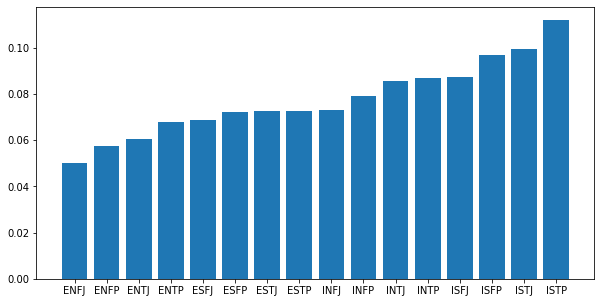

In [236]:
plt.figure(figsize = (10,5))
plt.bar(tweet_sum.index, height = tweet_mean ['TTR'])

## 5. VAD sentiment analysis

In [237]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [238]:
def VAD(posts):
    analyzer = SentimentIntensityAnalyzer()
    return analyzer.polarity_scores(posts)

In [292]:
tweet_clean['join_t'] = tweet_clean.link_free_without_emoji.apply(''.join)

In [293]:
tweet_clean['VAD'] = tweet_clean['join_t'].apply(VAD)

In [294]:
tweet_clean['VAD'][:5].tolist()

[{'neg': 0.007, 'neu': 0.799, 'pos': 0.194, 'compound': 0.9889},
 {'neg': 0.0, 'neu': 0.933, 'pos': 0.067, 'compound': 0.5562},
 {'neg': 0.051, 'neu': 0.68, 'pos': 0.269, 'compound': 0.9812},
 {'neg': 0.0, 'neu': 0.798, 'pos': 0.202, 'compound': 0.7825},
 {'neg': 0.033, 'neu': 0.647, 'pos': 0.32, 'compound': 0.9924}]

# 6. NRC emotion

In [283]:
from nrclex import NRCLex

In [284]:
def NRC_emotion(posts):
    emotion = NRCLex(posts)
    return emotion.affect_frequencies

In [285]:
def top_emotions (posts):
    emotion = NRCLex(posts)
    return emotion.top_emotions

In [287]:
tweet_clean['NRC_emotion'] = tweet_clean['join_t'].apply(NRC_emotion)
tweet_clean['top_emotion'] = tweet_clean['join_t'].apply(top_emotions)

In [290]:
tweet_sentiment_feature = tweet_clean[['MBTI','name','VAD','NRC_emotion','top_emotion']]

In [291]:
tweet_sentiment_feature

,MBTI,name,VAD,NRC_emotion,top_emotion
0,ENTP,BarackObama,"{'neg': 0.007, 'neu': 0.799, 'pos': 0.194, 'co...","{'fear': 0.01639344262295082, 'anger': 0.06557...","[(positive, 0.19672131147540983)]"
1,ESFP,justinbieber,"{'neg': 0.0, 'neu': 0.933, 'pos': 0.067, 'comp...","{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...","[(anticipation, 0.375)]"
2,ESFP,katyperry,"{'neg': 0.051, 'neu': 0.68, 'pos': 0.269, 'com...","{'fear': 0.07692307692307693, 'anger': 0.03846...","[(positive, 0.23076923076923078)]"
3,ISFP,rihanna,"{'neg': 0.0, 'neu': 0.798, 'pos': 0.202, 'comp...","{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...","[(fear, 0.0), (anger, 0.0), (anticip, 0.0), (t..."
4,ESFP,Cristiano,"{'neg': 0.033, 'neu': 0.647, 'pos': 0.32, 'com...","{'fear': 0.16666666666666666, 'anger': 0.08333...","[(trust, 0.3333333333333333)]"
...,...,...,...,...,...
418,ENFP,WillyrexYT,"{'neg': 0.056, 'neu': 0.897, 'pos': 0.047, 'co...","{'fear': 0.3333333333333333, 'anger': 0.333333...","[(fear, 0.3333333333333333), (anger, 0.3333333..."
419,ISTP,1future,"{'neg': 0.0, 'neu': 0.613, 'pos': 0.387, 'comp...","{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...","[(positive, 0.42857142857142855), (joy, 0.4285..."
420,INFJ,NASAHubble,"{'neg': 0.013, 'neu': 0.942, 'pos': 0.044, 'co...","{'fear': 0.034482758620689655, 'anger': 0.0689...","[(positive, 0.27586206896551724)]"
421,ENTJ,jimmycarr,"{'neg': 0.0, 'neu': 0.853, 'pos': 0.147, 'comp...","{'fear': 0.2, 'anger': 0.2, 'anticip': 0.0, 't...","[(fear, 0.2), (anger, 0.2), (negative, 0.2), (..."
